In [1]:
import os, sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer
import tonic

         Only Prophesee DVS demo will not run properly.
         Please install it from https://github.com/prophesee-ai/prophesee-automotive-dataset-toolbox


/Users/apple/miniconda3/envs/dev-snn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
sensor_size = tonic.datasets.NMNIST.sensor_size

frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, n_time_bins=3)

# converts structured numpy arrays to unstructured ones
int_transform = tonic.transforms.NumpyAsType(int)

transform_compose = tonic.transforms.Compose([
    frame_transform,
    int_transform
])

nmnist_train = tonic.datasets.NMNIST(save_to="../../data", train=True, transform=transform_compose)
nmnist_test = tonic.datasets.NMNIST(save_to="../../data", train=False, transform=transform_compose)

In [57]:
train_loader = DataLoader(dataset=nmnist_train, num_workers=2, shuffle=True)
test_loader  = DataLoader(dataset=nmnist_test, num_workers=2, shuffle=True)

In [58]:
def plot_frames(frames):
    fig, axes = plt.subplots(1, len(frames))
    for axis, frame in zip(axes, frames):
        axis.imshow(frame[1] - frame[0])
        axis.axis("off")
    plt.tight_layout()

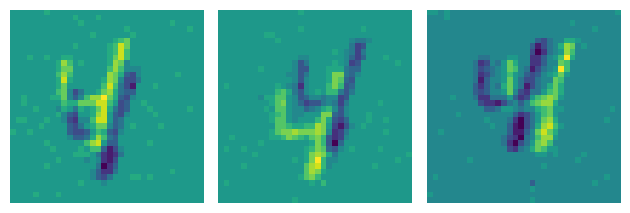

In [59]:
frames, target = next(iter(train_loader))

plot_frames(frames.squeeze())

In [51]:
frames.shape  # torch.Size([1, 3, 2, 34, 34]) => (batch_size, time_steps, height, width, channels)

torch.Size([1, 3, 2, 34, 34])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.0].


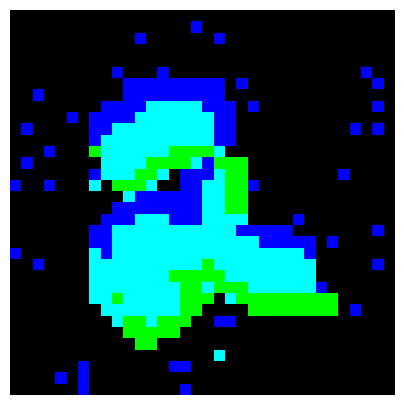

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.0].


In [29]:
animation = tonic.utils.plot_animation(frames.squeeze())

# Display the animation inline in a Jupyter notebook
from IPython.display import HTML
HTML(animation.to_jshtml())

In [60]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,     
            }
        
        neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}
        
        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params_drop, 3*2*34*34, 1024, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params_drop, 1024, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 512, 10, weight_norm=True),
            ])
    
    def forward(self, spike):
        # Input: [batch, channels, time, height, width] = [1, 2, 3, 34, 34]
        batch_size, channels, time_steps, height, width = spike.shape
        spike = spike.reshape(batch_size, channels * time_steps * height * width, 1, 1, 1).type(torch.long)
        
        for block in self.blocks:
            spike = block(spike)
        return spike
    
    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

In [61]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

device = torch.device('cpu')
# device = torch.device('cuda') 

net = Network().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [62]:

error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device)

In [63]:
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

In [64]:
epochs = 100

for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader): # training loop
        output = assistant.train(input, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    for i, (input, label) in enumerate(test_loader): # training loop
        output = assistant.test(input, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    if epoch%20 == 19: # cleanup display
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        stats_str = str(stats).replace("| ", "\n")
        print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')
    
    if stats.testing.best_accuracy:
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    net.grad_flow(trained_folder + '/')

RuntimeError: expected scalar type Long but found Float